# Set up 

## Check Environment 

In [530]:
import boto3

region = boto3.Session().region_name
session = boto3.session.Session()

ec2 = boto3.Session().client(service_name="ec2", region_name=region)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

## Update IAM Roles and Policies

In [531]:
import sagemaker
import time
from time import gmtime, strftime

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

from botocore.config import Config

config = Config(retries={"max_attempts": 10, "mode": "adaptive"})

iam = boto3.client("iam", config=config)

In [532]:
role_name = role.split("/")[-1]

print("Role name: {}".format(role_name))

Role name: LabRole


## Import Libraries

In [533]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
! pip install descartes
! pip install geopandas
!pip install wordcloud
import geopandas as gpd
from tqdm import tqdm  
from geopandas import GeoDataFrame, points_from_xy
from wordcloud import WordCloud

In [534]:
s3_public_path = "s3://sagemaker-studio-458903497716-h2kl4ff3dz/data"
s3_public_path_1="s3://sagemaker-studio-458903497716-h2kl4ff3dz/census_2010_data"
s3_public_path_2="s3://sagemaker-studio-458903497716-h2kl4ff3dz/state_abbrev_data"
s3_public_path_3="s3://sagemaker-studio-458903497716-h2kl4ff3dz/congress_data"
s3_public_path_4="s3://sagemaker-studio-458903497716-h2kl4ff3dz/state_income_data"
s3_public_path_5="s3://sagemaker-studio-458903497716-h2kl4ff3dz/cities_data"

In [535]:
%store s3_public_path
%store s3_public_path_1
%store s3_public_path_2
%store s3_public_path_3
%store s3_public_path_4
%store s3_public_path_5

Stored 's3_public_path' (str)
Stored 's3_public_path_1' (str)
Stored 's3_public_path_2' (str)
Stored 's3_public_path_3' (str)
Stored 's3_public_path_4' (str)
Stored 's3_public_path_5' (str)


In [536]:
s3_private_path = "s3://{}/gun_violence_data".format(bucket)
s3_private_path_1 = "s3://{}/census2010_data".format(bucket)
s3_private_path_2 = "s3://{}/state_abbrev_data".format(bucket)
s3_private_path_3= "s3://{}/congress_data".format(bucket)
s3_private_path_4= "s3://{}/state_income_data".format(bucket)
s3_private_path_5= "s3://{}/cities_data".format(bucket)

print(s3_private_path)
print(s3_private_path_1)
print(s3_private_path_2)
print(s3_private_path_3)
print(s3_private_path_4)
print(s3_private_path_5)

s3://sagemaker-us-east-1-898900188658/gun_violence_data
s3://sagemaker-us-east-1-898900188658/census2010_data
s3://sagemaker-us-east-1-898900188658/state_abbrev_data
s3://sagemaker-us-east-1-898900188658/congress_data
s3://sagemaker-us-east-1-898900188658/state_income_data
s3://sagemaker-us-east-1-898900188658/cities_data


In [537]:
%store s3_private_path
%store s3_private_path_1
%store s3_private_path_2
%store s3_private_path_3
%store s3_private_path_4
%store s3_private_path_5

Stored 's3_private_path' (str)
Stored 's3_private_path_1' (str)
Stored 's3_private_path_2' (str)
Stored 's3_private_path_3' (str)
Stored 's3_private_path_4' (str)
Stored 's3_private_path_5' (str)


In [538]:
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --include "*" 
!aws s3 cp --recursive $s3_public_path_1/ $s3_private_path_1/ --include "*"
!aws s3 cp --recursive $s3_public_path_2/ $s3_private_path_2/ --include "*" 
!aws s3 cp --recursive $s3_public_path_3/ $s3_private_path_3/ --include "*" 
!aws s3 cp --recursive $s3_public_path_4/ $s3_private_path_4/ --include "*" 
!aws s3 cp --recursive $s3_public_path_5/ $s3_private_path_5/ --include "*" 

copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/data/gun_violence.csv to s3://sagemaker-us-east-1-898900188658/gun_violence_data/gun_violence.csv
copy: s3://sagemaker-studio-458903497716-h2kl4ff3dz/census_2010_data/sub_est2018_all.csv to s3://sagemaker-us-east-1-898900188658/census2010_data/sub_est2018_all.csv
copy failed: s3://sagemaker-studio-458903497716-h2kl4ff3dz/state_abbrev_data/state_abbrev_map.csv to s3://sagemaker-us-east-1-898900188658/state_abbrev_data/state_abbrev_map.csv An error occurred (AccessDenied) when calling the CopyObject operation: Access Denied
copy failed: s3://sagemaker-studio-458903497716-h2kl4ff3dz/congress_data/Congress_2013-2018.csv to s3://sagemaker-us-east-1-898900188658/congress_data/Congress_2013-2018.csv An error occurred (AccessDenied) when calling the CopyObject operation: Access Denied
copy failed: s3://sagemaker-studio-458903497716-h2kl4ff3dz/state_income_data/all_states_income.csv to s3://sagemaker-us-east-1-898900188658/state_income_data/al

# Create Database Schema in Athena

In [539]:
import boto3
import sagemaker

sess = sagemaker.Session()
#bucket = '{}/gunData'.format(bucket)
bucket = '{}'.format(bucket)
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
bucket

'sagemaker-us-east-1-898900188658'

In [540]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [541]:
#assign database name
database_name = "ads508"

In [542]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [543]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [544]:
#create new database 'ads508'
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
create_db = pd.read_sql(statement, conn)
create_db

""


In [545]:
#verify database creation
q = "SHOW DATABASES"
db_show = pd.read_sql(q, conn)
db_show

,database_name
0,ads508
1,default
2,dsoaws


## Create Athena Tables

In [546]:
# Set Athena parameters
database_name = "ads508"
table_name_csv = "gun_violence"
s3_path = "s3://{}/gun_violence_data".format(bucket)
print(s3_path)

s3://sagemaker-us-east-1-898900188658/gun_violence_data


In [547]:
# SQL statement to execute
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
         incident_id int,
         date date,
         state string,
         city_or_county string,
         address string,
         n_killed int,
         n_injured int,
         incident_url string,
         source_url string,
         incident_url_fields_missing string,
         congressional_district int,
         gun_stolen string,
         gun_type string,
         incident_characteristics string,
         latitude int,
         location_description string,
         longitude int,
         n_guns_involved int,
         notes string,
         participant_age string,
         participant_age_group string,
         participant_gender string,
         participant_name string,
         participant_relationship string,
         participant_status string,
         participant_type string,
         sources string,
         state_house_district int,
         state_senate_district int
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_path
)

create_table = pd.read_sql(statement, conn)
create_table

""


In [548]:
table_name_csv_1 = "est2018"
s3_path_1 = "s3://{}/census2010_data".format(bucket)
print(s3_path_1)

s3://sagemaker-us-east-1-898900188658/census2010_data


In [549]:
# SQL statement to execute

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
    sumlev int,
    state int,
    county int,
    place int,
    cousub int,
    concit int,
    primgeo_flag int,
    funcstat int,
    name string,
    stname string,
    census2010pop int,
    estimatesbase2010 int,
    popestimates2010 int,
    popestimates2011 int,
    popestimates2012 int,
    popestimates2013 int,
    popestimates2014 int,
    popestimates2015 int,
    popestimates2016 int,
    popestimates2017 int,
    popestimates2018 int
         
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_1, s3_path_1
)

create_table_1 = pd.read_sql(statement, conn)
create_table_1

""


In [550]:
table_name_csv_2 = "state_abbrev"
s3_path_2 = "s3://{}/state_abbrev_data".format(bucket)
print(s3_path_2)

s3://sagemaker-us-east-1-898900188658/state_abbrev_data


In [551]:
# SQL statement to execute

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
   state string,
   abbrev string,
   code string
         
) ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_2, s3_path_2
)

create_table_2 = pd.read_sql(statement, conn)
create_table_2

""


In [552]:
table_name_csv_3 = "congress_2013_to_2018"
s3_path_3 = "s3://{}/congress_data".format(bucket)
print(s3_path_3)

s3://sagemaker-us-east-1-898900188658/congress_data


In [553]:
# SQL statement to execute

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
 id string,
 name string,
 sort_name string,
 email string,
 twitter string,
 facebook string,
 group string,
 group_id string,
 state string,
 district int,
 chamber string,
 year int,
 start_date date,
 end_date date,
 image string,
 gender string,
 wikidata string,
 wikidata_group string,
 wikidata_area string
 
         
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_3, s3_path_3
)

create_table_3 = pd.read_sql(statement, conn)
create_table_3

""


In [554]:
table_name_csv_4 = "state_income"
s3_path_4 = "s3://{}/state_income_data".format(bucket)
print(s3_path_4)

s3://sagemaker-us-east-1-898900188658/state_income_data


In [555]:
# SQL statement to execute

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
 id int,
 zipcode int,
 agi int,
 avg_agi int,
 groups string,
 avg_income int
 
         
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_4, s3_path_4
)

create_table_4 = pd.read_sql(statement, conn)
create_table_4

""


In [556]:
table_name_csv_5 = "cities"
s3_path_5 = "s3://{}/cities_data".format(bucket)
print(s3_path_5)

s3://sagemaker-us-east-1-898900188658/cities_data


In [557]:
# SQL statement to execute

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
    city string,
    city_ascii string,
    state_id string,
    state_name string,
    county_fips int,
    county_name string,
    lat string,
    lng string,
    population string,
    density string,
    source string,
    military string,
    incorporated string,
    timezone string,
    ranking int,
    zips string,
    id int)
    
ROW FORMAT SERDE 
  'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
WITH SERDEPROPERTIES ( 
  'quoteChar'='\"', 
  'separatorChar'=',') 
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv_5, s3_path_5
)

create_table_5 = pd.read_sql(statement, conn)
create_table_5

""


In [558]:
statement = "SHOW TABLES in ads508"
tables = pd.read_sql(statement, conn)
tables

,tab_name
0,cities
1,congress_2013_to_2018
2,est2018
3,gun_violence
4,state_abbrev
5,state_income


In [559]:
statement = "SELECT * from ads508.gun_violence LIMIT 100"
df = pd.read_sql(statement, conn)
df.head(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district


In [560]:
statement = "SELECT * from ads508.est2018 LIMIT 100"
df_pop = pd.read_sql(statement, conn)
df_pop.head(5)

,sumlev,state,county,place,cousub,concit,primgeo_flag,funcstat,name,stname,...,estimatesbase2010,popestimates2010,popestimates2011,popestimates2012,popestimates2013,popestimates2014,popestimates2015,popestimates2016,popestimates2017,popestimates2018


In [561]:
statement = "SELECT * from ads508.congress_2013_to_2018 LIMIT 100"
df_cong = pd.read_sql(statement, conn)
df_cong.head(5)

,id,name,sort_name,email,twitter,facebook,group,group_id,state,district,chamber,year,start_date,end_date,image,gender,wikidata,wikidata_group,wikidata_area


In [562]:
statement = "SELECT * from ads508.state_abbrev LIMIT 100"
df_abbrev = pd.read_sql(statement, conn)
df_abbrev.head(5)

,state,abbrev,code


In [563]:
statement = "SELECT * from ads508.state_income LIMIT 100"
df_income = pd.read_sql(statement, conn)
df_income.head(5)

,id,zipcode,agi,avg_agi,groups,avg_income


In [564]:
statement = "SELECT * from ads508.cities LIMIT 100"
df_cities = pd.read_sql(statement, conn)
df_cities.head(5)

,city,city_ascii,state_id,state_name,county_fips,county_name,lat,lng,population,density,source,military,incorporated,timezone,ranking,zips,id


# Insert Dataset into Pandas Dataframe

In [565]:
df = pd.read_csv("{}/gun_violence.csv".format(s3_path))
df.head()

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0


In [566]:
df_cities = pd.read_csv("{}/uscities.csv".format(s3_path_5))
df_cities.head()

FileNotFoundError: sagemaker-us-east-1-898900188658/cities_data/uscities.csv

# Data Overview

In [567]:
print(df.shape)

(239677, 29)


### The dataset contains 239,677 rows and 29 attributes. 

## Show data types

In [568]:
df.dtypes

incident_id                      int64
date                            object
state                           object
city_or_county                  object
address                         object
n_killed                         int64
n_injured                        int64
incident_url                    object
source_url                      object
incident_url_fields_missing       bool
congressional_district         float64
gun_stolen                      object
gun_type                        object
incident_characteristics        object
latitude                       float64
location_description            object
longitude                      float64
n_guns_involved                float64
notes                           object
participant_age                 object
participant_age_group           object
participant_gender              object
participant_name                object
participant_relationship        object
participant_status              object
participant_type         

## Show null counts

In [569]:
df.isnull().sum()

incident_id                         0
date                                0
state                               0
city_or_county                      0
address                         16497
n_killed                            0
n_injured                           0
incident_url                        0
source_url                        468
incident_url_fields_missing         0
congressional_district          11944
gun_stolen                      99498
gun_type                        99451
incident_characteristics          326
latitude                         7923
location_description           197588
longitude                        7923
n_guns_involved                 99451
notes                           81017
participant_age                 92298
participant_age_group           42119
participant_gender              36362
participant_name               122253
participant_relationship       223903
participant_status              27626
participant_type                24863
sources     

## Show percentage of null values

In [570]:
100*(df.isnull().sum())/len(df.index)

incident_id                     0.000000
date                            0.000000
state                           0.000000
city_or_county                  0.000000
address                         6.883013
n_killed                        0.000000
n_injured                       0.000000
incident_url                    0.000000
source_url                      0.195263
incident_url_fields_missing     0.000000
congressional_district          4.983373
gun_stolen                     41.513370
gun_type                       41.493760
incident_characteristics        0.136016
latitude                        3.305699
location_description           82.439283
longitude                       3.305699
n_guns_involved                41.493760
notes                          33.802576
participant_age                38.509327
participant_age_group          17.573234
participant_gender             15.171251
participant_name               51.007397
participant_relationship       93.418643
participant_stat

## Describe all numeric variables

In [571]:
df.describe()

,incident_id,n_killed,n_injured,congressional_district,latitude,longitude,n_guns_involved,state_house_district,state_senate_district
count,2.396770e+05,239677.000000,239677.000000,227733.000000,231754.000000,231754.000000,140226.000000,200905.000000,207342.00000
mean,5.593343e+05,0.252290,0.494007,8.001265,37.546598,-89.338348,1.372442,55.447132,20.47711
std,2.931287e+05,0.521779,0.729952,8.480835,5.130763,14.359546,4.678202,42.048117,14.20456
min,9.211400e+04,0.000000,0.000000,0.000000,19.111400,-171.429000,1.000000,1.000000,1.00000
25%,3.085450e+05,0.000000,0.000000,2.000000,33.903400,-94.158725,1.000000,21.000000,9.00000
50%,5.435870e+05,0.000000,0.000000,5.000000,38.570600,-86.249600,1.000000,47.000000,19.00000
75%,8.172280e+05,0.000000,1.000000,10.000000,41.437375,-80.048625,1.000000,84.000000,30.00000
max,1.083472e+06,50.000000,53.000000,53.000000,71.336800,97.433100,400.000000,901.000000,94.00000


## Describe all string variables

In [572]:
df.describe(include=[object])

,date,state,city_or_county,address,incident_url,source_url,gun_stolen,gun_type,incident_characteristics,location_description,notes,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources
count,239677,239677,239677,223180,239677,239209,140179,140226,239351,42089,158660,147379,197558,203315,117424,15774,212051,214814,239068
unique,1725,51,12898,198037,239677,213989,349,2502,18126,27595,136652,18951,898,873,113488,284,2150,259,217280
top,2017-01-01,Illinois,Chicago,2375 International Pkwy,http://www.gunviolencearchive.org/incident/461105,http://blog.tsa.gov,0::Unknown,0::Unknown,Shot - Wounded/Injured,Austin,man shot,0::24,0::Adult 18+,0::Male,0::Officer,1::Significant others - current or former,0::Injured,0::Victim,http://blog.tsa.gov
freq,342,17556,10814,160,1,1092,121310,93559,47541,240,501,3814,94671,93496,144,2651,42293,58564,1092


## Check for duplicates in the DataFrame

In [573]:
duplicate_rows = df[df.duplicated()].count()

# print duplicate rows
print("Duplicate Rows Per Column : ")
print(duplicate_rows)

Duplicate Rows Per Column : 
incident_id                    0
date                           0
state                          0
city_or_county                 0
address                        0
n_killed                       0
n_injured                      0
incident_url                   0
source_url                     0
incident_url_fields_missing    0
congressional_district         0
gun_stolen                     0
gun_type                       0
incident_characteristics       0
latitude                       0
location_description           0
longitude                      0
n_guns_involved                0
notes                          0
participant_age                0
participant_age_group          0
participant_gender             0
participant_name               0
participant_relationship       0
participant_status             0
participant_type               0
sources                        0
state_house_district           0
state_senate_district          0
dtype: int64


## Impute Values for State and Senate Districts based on city and state names and save it to the CSV so that the operation only needs to be done once.

In [574]:
# df['city_state_concat'] = df['city_or_county'] + ', ' + df['state'].astype(str)

# # Group the DataFrame by city_state_concat and filter for NaN values in state_house_district and state_senate_district
# nan_districts_df = df.groupby('city_state_concat').filter(lambda x: x['state_house_district'].isna().any() or x['state_senate_district'].isna().any())
# nan_districts_df = nan_districts_df[(nan_districts_df['state_house_district'].isna()) | (nan_districts_df['state_senate_district'].isna())]

# unique_cities_and_states = (nan_districts_df['city_state_concat'].unique())
# unique_cities_and_states

# for cities in unique_cities_and_states:
     
#     # filter the data to only include rows for the selected city and state
#     city_data = df[(df['city_state_concat'] == cities)]

#     # get the non-null values for state_house_district and state_senate_district
#     house_district_values = city_data['state_house_district'].dropna()
#     senate_district_values = city_data['state_senate_district'].dropna()

#     # impute missing values using the median of the non-null values
#     df.loc[(df['city_state_concat'] == cities) & (df['state_house_district'].isnull()), 
#            'state_house_district'] = house_district_values.median()
#     df.loc[(df['city_state_concat'] == cities) & (df['state_senate_district'].isnull()), 
#            'state_senate_district'] = senate_district_values.median()

# # Drop rows where state_house_district is still blank after the for loop
# # This would mean that the city does not have any rows with a value for 
# # state_house_district or does not have rows with a value for state_senate_district.
# df = df.dropna(subset=['state_house_district'])
# df = df.dropna(subset=['state_senate_district'])

# print(df.head())

In [575]:
# Save the updated DataFrame to a new CSV file
# df.to_csv("{}/gun_violence.csv".format(s3_path), index=False)

In [576]:
# Assuming you have a DataFrame named `df` with columns 'n_killed' and 'n_injured'
target_class = []

for index, row in df.iterrows():
    if row['n_killed'] > 0 or row['n_injured'] > 0:
        target_class.append(1)
    else:
        target_class.append(0)

df['target_class'] = target_class

#convert target class into a categorical variable
df['target_class'].astype('category')

0         1
1         1
2         1
3         1
4         1
         ..
239672    0
239673    1
239674    1
239675    1
239676    1
Name: target_class, Length: 239677, dtype: category
Categories (2, int64): [0, 1]

In [577]:
df.head(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,target_class
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN,1
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0,1
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0,1
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0,1
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0,1


# Imputing for Null Values

## Number of Guns Involved ('n_guns_involved')

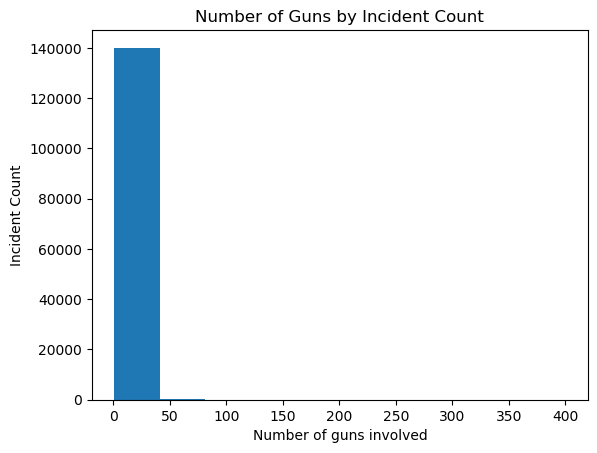

In [578]:
#The number of guns involved is heavily right skewed, with the highest number of >400, while most incidents involve <50 guns. 

plt.hist(df['n_guns_involved'])
plt.xlabel("Number of guns involved")
plt.ylabel("Incident Count")
plt.title("Number of Guns by Incident Count")

plt.show()

In [579]:
#Closer inspection shows that over half of all incidents involve 1 gun (53.2%) 
guns_inv=(df['n_guns_involved'].value_counts())/(len(df.index))
guns_inv

1.0      0.532166
2.0      0.031196
3.0      0.008432
4.0      0.003634
5.0      0.001815
           ...   
158.0    0.000004
189.0    0.000004
85.0     0.000004
96.0     0.000004
127.0    0.000004
Name: n_guns_involved, Length: 106, dtype: float64

In [580]:
df['n_guns_involved'].describe()

count    140226.000000
mean          1.372442
std           4.678202
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         400.000000
Name: n_guns_involved, dtype: float64

The mean and mode for the number of guns involved is both 1. Thus, we will impute 1 for all null values in 'n_guns_involved'

In [581]:
df['n_guns_involved'].fillna(value=1, inplace=True)

## Impute for Missing Latitude/Longitude

In [582]:
# Merge the two dataframes on city and state columns
merged_cities= pd.merge(df, df_cities,left_on=['city_or_county', 'state'], right_on=['city', 'state_name'],  how='left')

# Update missing latitude and longitude values
df['latitude'].fillna(merged_cities['lat'], inplace=True)
df['longitude'].fillna(merged_cities['lng'], inplace=True)

# Confirm imputation
df.isnull().sum()

incident_id                         0
date                                0
state                               0
city_or_county                      0
address                         16497
n_killed                            0
n_injured                           0
incident_url                        0
source_url                        468
incident_url_fields_missing         0
congressional_district          11944
gun_stolen                      99498
gun_type                        99451
incident_characteristics          326
latitude                         7923
location_description           197588
longitude                        7923
n_guns_involved                     0
notes                           81017
participant_age                 92298
participant_age_group           42119
participant_gender              36362
participant_name               122253
participant_relationship       223903
participant_status              27626
participant_type                24863
sources     

# Feature Creation

## Create 'region' based on geographical division 

The U.S Census Bureau groups the 50 states and the District of Columbia into nine divisions based on geographic proximity. 

The nine divisions are:
    
    New England: Includes Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, and Vermont
    
    Middle Atlantic: Includes New Jersey, New York, and Pennsylvania
    
    East North Central: Includes Illinois, Indiana, Michigan, Ohio, and Wisconsin
    
    West North Central: Includes Iowa, Kansas, Minnesota, Missouri, Nebraska, North Dakota, and South Dakota
    
    South Atlantic: Includes Delaware, District of Columbia, Florida, Georgia, Maryland, North Carolina, South Carolina, Virginia, and West Virginia
    
    East South Central: Includes Alabama, Kentucky, Mississippi, and Tennessee
    
    West South Central: Includes Arkansas, Louisiana, Oklahoma, and Texas
    
    Mountain: Includes Arizona, Colorado, Idaho, Montana, Nevada, New Mexico, Utah, and Wyoming
    
    Pacific: Includes Alaska, California, Hawaii, Oregon, and Washington

In [583]:
# Create a dictionary that maps states to geographical divisions
state_regions = {
                 'New England': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont'],
                 'Middle Atlantic': ['New Jersey', 'New York', 'Pennsylvania'],
                 'East North Central': ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin'],
                 'West North Central': ['Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'],
                 'South Atlantic': ['Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Maryland', 'North Carolina', 'South Carolina', 'Virginia', 'West Virginia'],
                 'East South Central': ['Alabama', 'Kentucky', 'Mississippi', 'Tennessee'],
                 'West South Central': ['Arkansas', 'Louisiana', 'Oklahoma', 'Texas'],
                 'Mountain': ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming'],
                 'Pacific': ['Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']}

# Map the state names to geographical divisions and create a new 'region' column in the dataframe
df['region'] = df['state'].map({state: region for region, states in state_regions.items() for state in states})


# Analysis by Location

In [584]:
#2010 census information--state populations
statement = "SELECT stname, max(census2010pop) as pop_count from ads508.est2018 GROUP BY stname ORDER BY stname asc LIMIT 100"
state_pop=pd.read_sql(statement, conn)
state_pop=state_pop.tail(51)
state_pop

,stname,pop_count


In [585]:
# incident count by region

# Group the dataframe by 'region' and count the number of records in each group
region_counts = df.groupby('region').size().reset_index(name='incidents_count')

# Print the counts for each region
print(region_counts)

               region  incidents_count
0  East North Central            44575
1  East South Central            20853
2     Middle Atlantic            24028
3            Mountain            11991
4         New England            12286
5             Pacific            23664
6      South Atlantic            57834
7  West North Central            16469
8  West South Central            27977


In [586]:
## adjust for population 

#add 'region' to population table
state_pop['region'] = state_pop['stname'].map({state: region for region, states in state_regions.items() for state in states})

# Group the dataframe by 'region' and count the number of records in each group
region_pop = state_pop.groupby('region').sum()
region_pop

""
region


In [587]:
# adjust incident count by population per region 

merged_region=pd.merge(region_counts, region_pop, on='region')
merged_region=merged_region.drop('pop_count_x', axis=1)
merged_region['incident_rate']=merged_region['incidents_count']/merged_region['pop_count_y']
merged_region['incident_rate_per_100k']=merged_region['incident_rate']*100000
merged_region

KeyError: "['pop_count_x'] not found in axis"

In [ ]:
#show top 15 states w/ highest incident count
statement="SELECT state, count(*) as incident_count from ads508.gun_violence GROUP BY state ORDER BY count(*) DESC"
gb_state=pd.read_sql(statement, conn)
gb_state.iloc[2:16]

In [ ]:
#show incident rate per state
statement="SELECT state, count(*) as incident_count FROM ads508.gun_violence GROUP BY state ORDER BY state DESC LIMIT 100"
gb_state=pd.read_sql(statement, conn)
gb_state=gb_state.head(51).iloc[::-1] #reverse order so that states are in alphabetical top to bottom
gb_state['state_pop']=state_pop['pop_count']
gb_state['incident_rate']=gb_state['incident_count']/gb_state['state_pop']
gb_state['incident_rate_per_100k']=gb_state['incident_rate']*100000

gb_state

In [ ]:
#show top 15 cities w/ highest incident count
statement="SELECT state,city_or_county,count(*) as incident_count from ads508.gun_violence GROUP BY state, city_or_county ORDER BY count(*) DESC"
gb_city=pd.read_sql(statement, conn)
gb_city.head(16)

In [ ]:
#show top 15 congressional districts w/ highest incident count
statement="SELECT state,city_or_county,congressional_district, count(*) as incident_count from ads508.gun_violence GROUP BY state, city_or_county, congressional_district ORDER BY count(*) DESC"
gb_cong=pd.read_sql(statement, conn)
gb_cong.head(16)

## Use GeoPandas to map all gun violence incidents

In [ ]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.head()

In [ ]:
# wrap df w/ a GeoDataFrame by creating a geometry attribute
df_geo = GeoDataFrame(df, geometry=points_from_xy(df.longitude, df.latitude))
df_geo.head()

In [ ]:
#mapped incident counts by city

from matplotlib.pyplot import figure

united_states = GeoDataFrame.from_file('state_shapefiles/')
#north_america.plot(color='lightgrey')

axes = united_states.plot(color='lightgrey', edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.03*(gb_city['incident_count']), edgecolors='black')
plt.xlim(xmin=-180,xmax=-65)
plt.show()

In [ ]:
#mapped incident counts by city, zoomed into continental US

united_states = GeoDataFrame.from_file('state_shapefiles/')
#north_america.plot(color='lightgrey')
axes = united_states.plot(color='lightgrey',edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.03*(gb_city['incident_count']), edgecolors='black')
plt.xlim(xmin=-130,xmax=-65)
plt.ylim(ymin=23, ymax=50)
plt.show()

In [ ]:
#mapped incident counts by congressional districts

united_states = GeoDataFrame.from_file('congressional_district_shapefiles/')
#north_america.plot(color='lightgrey')
axes = united_states.plot(color='lightgrey',edgecolor='white')
axes.scatter(x=df['longitude'], y=df['latitude'], s=.03*(gb_cong['incident_count']), edgecolors='black')
plt.xlim(xmin=-130,xmax=-65)
plt.ylim(ymin=23, ymax=50)
plt.show()

## Most Frequent Gun Used Was 'Handgun'.  Significant portion of the dataset had record with gun type not recorded or known.

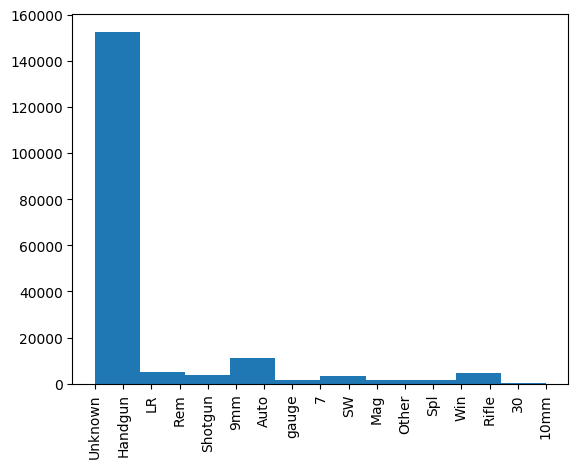

In [588]:
"""
Parse gun_type column and display histogram of gun type frequency

"""
import re
import math

guns_list = []

for item in df['gun_type']:

    if type(item) == float and math.isnan(item):
        continue

    gun = re.findall("\d*::\d* (?P<gun>\w*)", item)

    if len(gun) == 0:
        gun = re.findall("\d*::(?P<gun>\w*)", item)

    guns_list.extend(gun)

# print(guns_list)

plt.xticks(rotation="vertical")
plt.hist(guns_list)
plt.show()

/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


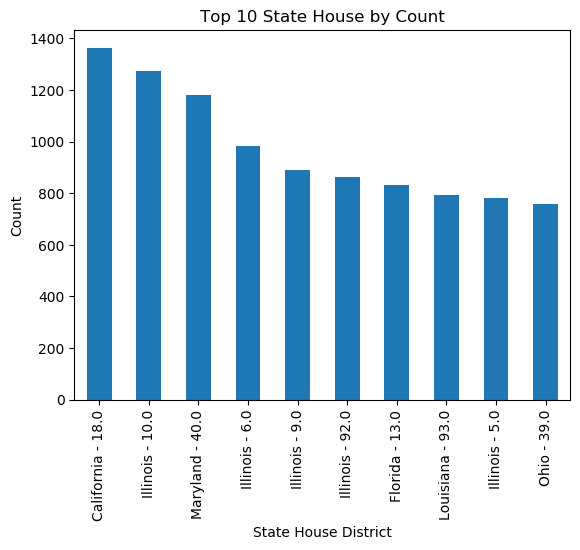

In [589]:
df_no_nans = df_geo.dropna(subset=['state_house_district'])

# Concatenate the state and state_house_district columns
df_no_nans['state_house_district'] = df_no_nans['state'] + ' - ' + df_no_nans['state_house_district'].astype(str)

# Get the top 10 state_districts by count
top10_districts = df_no_nans['state_house_district'].value_counts().nlargest(10)

# Plot the top 10 state_districts using a bar chart
top10_districts.plot(kind='bar')

# Add labels to the plot
plt.title('Top 10 State House by Count')
plt.xlabel('State House District')
plt.ylabel('Count')

# Show the plot
plt.show()

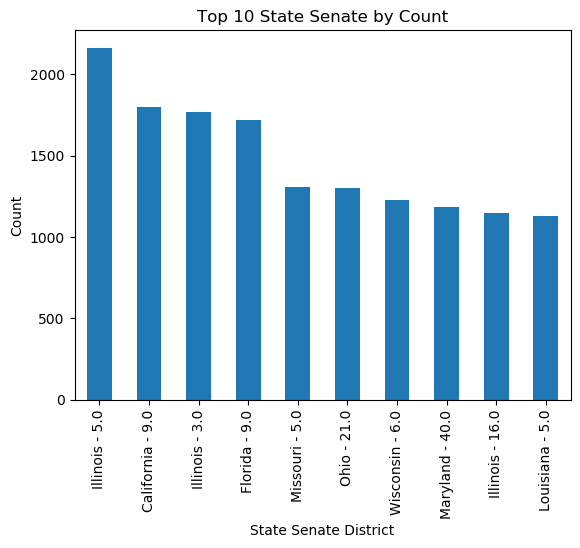

In [590]:
df_no_nans = df_geo.dropna(subset=['state_senate_district'])

# Concatenate the state and state_house_district columns
df_no_nans['state_senate_district'] = df_no_nans['state'] + ' - ' + df_no_nans['state_senate_district'].astype(str)

# Get the top 10 state_districts by count
top10_districts = df_no_nans['state_senate_district'].value_counts().nlargest(10)

# Plot the top 10 state_districts using a bar chart
top10_districts.plot(kind='bar')

# Add labels to the plot
plt.title('Top 10 State Senate by Count')
plt.xlabel('State Senate District')
plt.ylabel('Count')

# Show the plot
plt.show()

In [591]:
### Find the 10 most common words listed in the 'incident characteristics' column ###
### The regular expressions is used as a space delimiter, since some of the words ###
### are separated with spaces and others are separated with the "||" symbol ###

import re
from collections import Counter
import pandas as pd

df["incident_characteristics"] = df["incident_characteristics"].astype(str)

# create an empty Counter object
word_counts = Counter()

# loop through each row in the DataFrame
for index, row in df.iterrows():
    # split the "Incident_Characteristics" column into a list of words using a regular expression
    words = re.findall(r'\w+', row['incident_characteristics'])
    # update the Counter object with the words in this row
    word_counts.update(words)

# get the 10 most common words
most_common_words_10 = word_counts.most_common(10)

# print the results
print("The 10 most common words are:")
for word, count in most_common_words_10:
    print(f"{word}: {count}")

The 10 most common words are:
Shot: 147335
Wounded: 93926
Injured: 93926
Shooting: 79817
Incident: 76265
of: 73576
found: 71645
gun: 64222
suicide: 58307
or: 54245


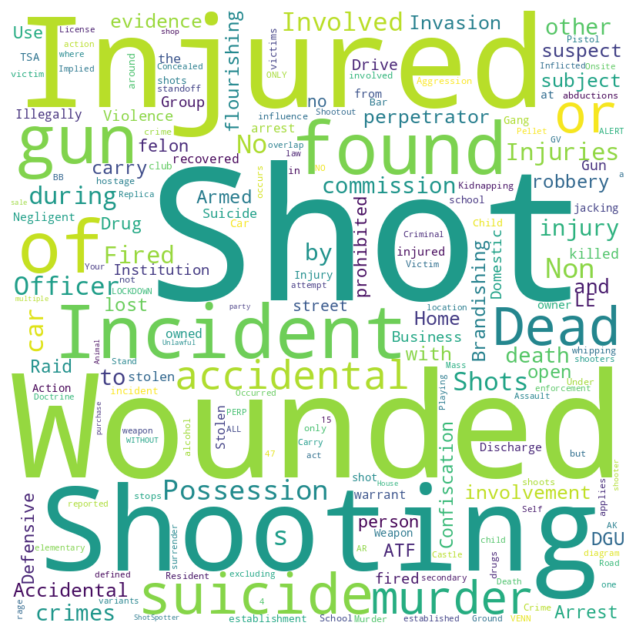

In [592]:
### Creating a word cloud of the most common words. Currently the count is 200, which ###
### feels like enough to get a good sense of the types of descriptive words used in ###
### the reports. ###

most_common_words_200 = word_counts.most_common(200)
most_common_words_dict = dict(most_common_words_200)

wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(most_common_words_dict)

# plot the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [593]:
# break up Participant Gender
# import matplotlib.pyplot as plt

# participant_gender = df['participant_gender']
# cleaned_row = []

# for row in participant_gender:
#     regex = 'Male'
#     match_males = re.findall(regex, str(row))

#     regex = 'Female'
#     match_females = re.findall(regex, str(row))

#     if match_males != None:
#         cleaned_row = cleaned_row + match_males
#     if match_females != None:
#         cleaned_row = cleaned_row + match_females

# plt.hist(cleaned_row)
# plt.show()

## Out Of All Gun Violence Incidents Recorded, There Are In Total More Suspects Than Victims

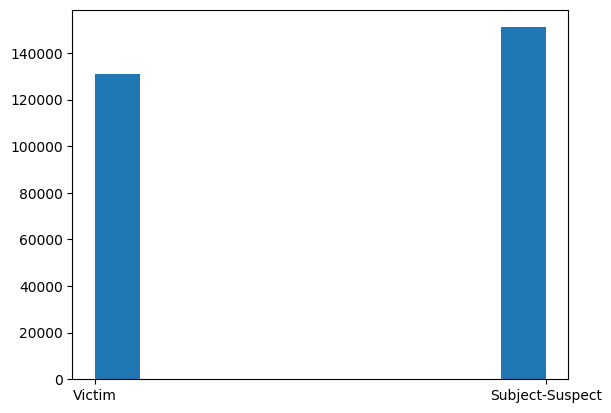

In [594]:
participant_type = df['participant_type']
cleaned = []

for parts in participant_type:

    if '||' in str(parts):
        part = str(parts).split('||')
        
        for keyval in part:
            if '::' in str(keyval):
                
                part_value = str(keyval).split('::')
                cleaned.append(part_value[1])

plt.hist(cleaned)
plt.show()

##  Overwhelming Majority of Gun Violence Incidents Involved 0 or 1 Suspects

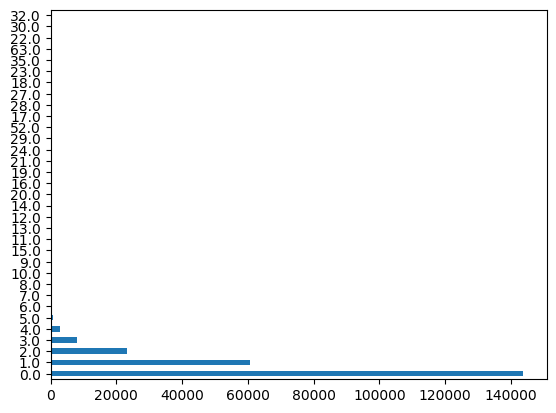

In [595]:
"""
Parse 'participant_type' column and count the total number of Victims and Suspects Per Row
Create New Column that keeps count of victims and count of suspects per row
"""

participant_type = df['participant_type']

i = 0

for parts in participant_type:

    suspects = []
    victims = []

    if '||' in str(parts):
        part = str(parts).split('||')
        for keyval in part:
            if '::' in str(keyval):
                part_value = str(keyval).split('::')
                if part_value[1] == 'Victim':
                    victims.append(part_value[1])
                elif part_value[1] == 'Subject-Suspect':
                    suspects.append(part_value[1])

    df.at[i,'victim_count'] = len(victims)
    df.at[i,'suspect_count'] = len(suspects)
    i = i + 1

plt.clf()
#plt.hist(df['suspect_count'], range=[0,7])
#print(df['suspect_count'].value_counts())
df['suspect_count'].value_counts().plot(kind='barh')
plt.show()

## Overwhelming Majority Of Victims Totalled 0 or 1 Per Incident

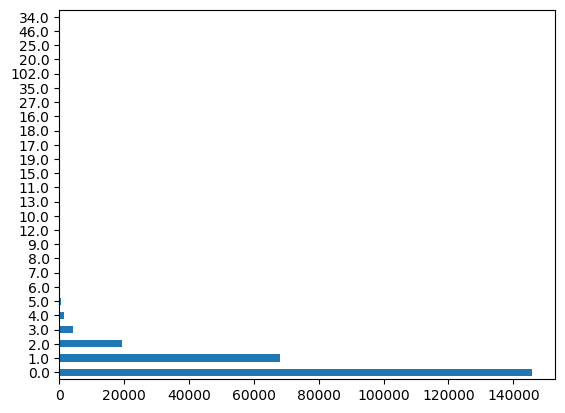

In [596]:
plt.clf()
df['victim_count'].value_counts().plot(kind='barh')
plt.show()

## Most Frequent Incident Characteristics Recorded for Gun Violence Incidents Where 0 People Were Injured And 0 People Were Killed

Number of incidents where injured = 0 and killed = 0: 97287
Total rows in dataframe: 239677
Percentage of none injured and none killed: 0.405909


<Figure size 640x480 with 0 Axes>

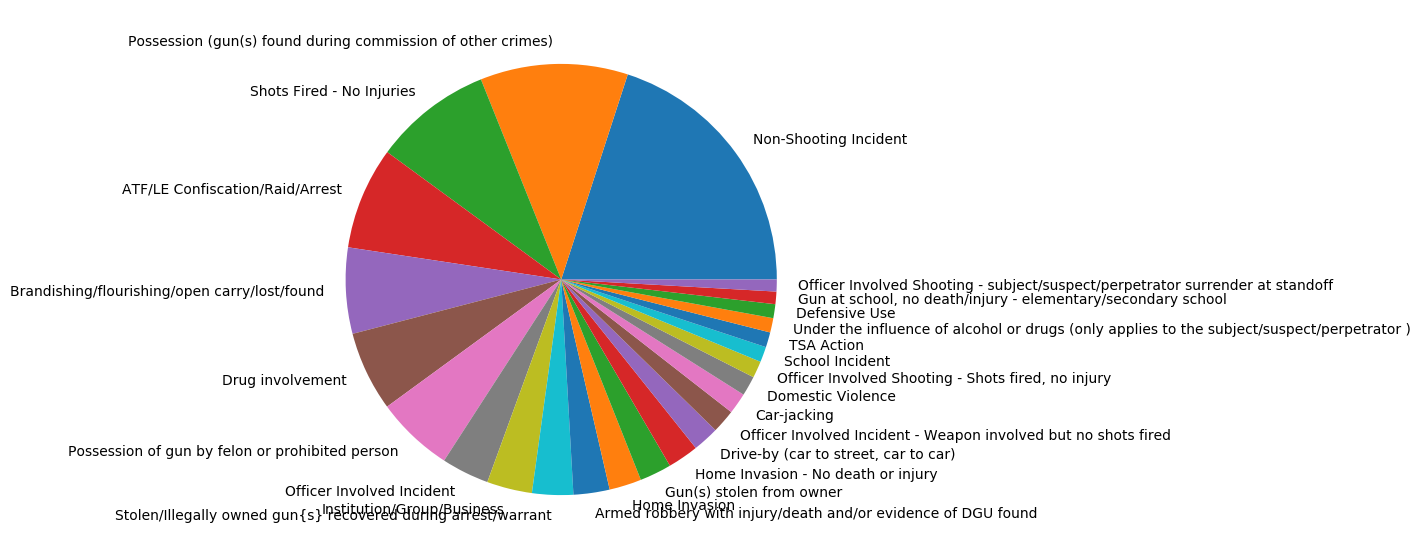

In [597]:
from collections import Counter

phrases_list = []
count = 0

for i, row in df.iterrows():
    if (row['n_injured'] == 0 and row['n_killed'] == 0):
        count = count + 1
        #print(row['incident_characteristics'])
 
        if not isinstance(row['incident_characteristics'], float):

            incident_text = row['incident_characteristics']
            
            if '||' in str(incident_text):
                item = str(incident_text).split('||')
                
                for phrases in item:
                    phrases_list.append(phrases)


print("Number of incidents where injured = 0 and killed = 0: %d" % count)
print("Total rows in dataframe: %d" % len(df))
print("Percentage of none injured and none killed: %f" % (count/len(df)))


most_common_words_20 = Counter(phrases_list).most_common(25)
#print("\n\n25 Most Common Phrases in Incident Characteristics column:")
#for word, count in most_common_words_20:
#    print(f"{word}: {count}")

# Represent 20 Most Common Incident Characteristics as Pie Chart
# This is for the incidents where no one was injured or killed
words = []
counts = []

for word, count in most_common_words_20:
    words.append(word)
    counts.append(count)

temp = []
for c in counts:
    temp.append(c/len(counts))
    
plt.clf()
fig = plt.figure(figsize =(10, 7))
plt.pie(temp, labels = words)
plt.show()

## Most Frequent Incident Characteristics For Incidents With 1 or more Injured or Killed

<Figure size 640x480 with 0 Axes>

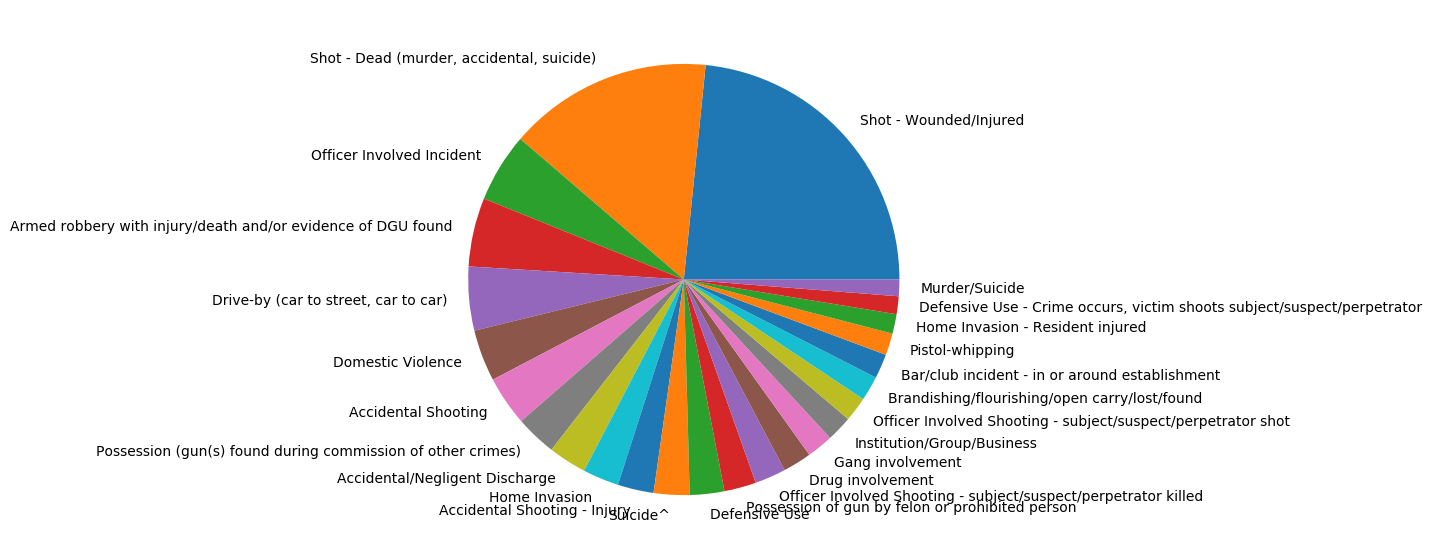

In [598]:
phrases_list = []
count = 0

for i, row in df.iterrows():

    if (row['n_injured'] >= 1 or row['n_killed'] >= 1):
        count = count + 1

        if not isinstance(row['incident_characteristics'], float):

            incident_text = row['incident_characteristics']

            if '||' in str(incident_text):
                item = str(incident_text).split('||')

                for phrases in item:
                    phrases_list.append(phrases)

most_common_words_20 = Counter(phrases_list).most_common(25)
words = []
counts = []

for word, count in most_common_words_20:
    words.append(word)
    counts.append(count)

temp = []
for c in counts:
    temp.append(c / len(counts))

plt.clf()
fig = plt.figure(figsize=(10, 7))
plt.pie(temp, labels=words)
plt.show()

# Analysis by Date

In [599]:
statement="SELECT year(date) as year, count(*) as incident_count, sum(n_killed) as total_killed, sum(n_injured) as total_injured from ads508.gun_violence GROUP BY year(date) ORDER BY year(date)"
year_count=pd.read_sql(statement, conn)
year_count

,year,incident_count,total_killed,total_injured


In [600]:
statement="SELECT year(date) as year, month(date) as month, count(*) as incident_count, sum(n_killed) as total_killed, sum(n_injured) as total_injured from ads508.gun_violence GROUP BY year(date), month(date) ORDER BY year(date), month(date)"
month_count=pd.read_sql(statement, conn)
month_count

,year,month,incident_count,total_killed,total_injured


# Analysis by Death/Injury Count

## Show the five deadliest shootings
### NOTE: Dataset does not include the Las Vegas shooting that occured October 1, 2017, which took the lives of 60 people.

In [601]:
statement="SELECT * FROM ads508.gun_violence ORDER BY n_killed desc LIMIT 10"
top_killed=pd.read_sql(statement, conn)
top_killed.head(5)


,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district


## Combine the number of individuals killed and injured to get number of total involved


In [602]:
df['n_total']=df['n_killed'] + df['n_injured']
df.head(5)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_status,participant_type,sources,state_house_district,state_senate_district,target_class,region,victim_count,suspect_count,n_total
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN,1,Middle Atlantic,4.0,1.0,4
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0,1,Pacific,4.0,1.0,4
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0,1,East North Central,3.0,2.0,4
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0,1,Mountain,3.0,1.0,4
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0,1,South Atlantic,3.0,1.0,4


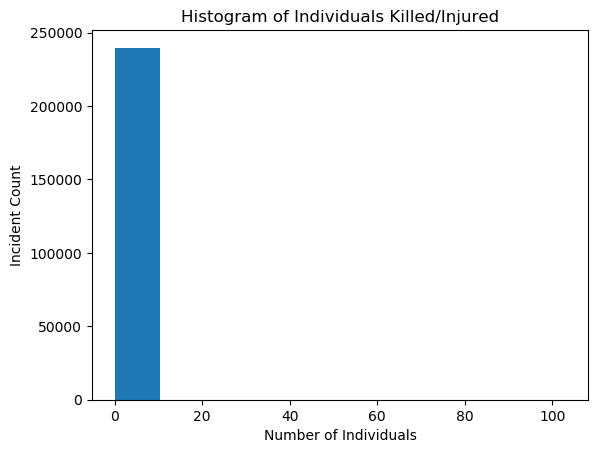

In [603]:
import matplotlib.ticker as mticker
plt.clf()
plt.hist(df['n_total'])
plt.xlabel('Number of Individuals')
plt.ylabel('Incident Count')
plt.title('Histogram of Individuals Killed/Injured')
plt.show()

## Count of incidents with no injuries/deaths

In [604]:
statement="SELECT count(*) as count FROM ads508.gun_violence WHERE n_injured=0 and n_killed=0"
no_injury=pd.read_sql(statement, conn)
no_injury

,count
0,0


## Most Suspects Belong To 'Adult 18+' Age Group, A Slightly Larger Portion Had No Age Group Recorded For Suspect

              118175
Adult 18+     112493
Teen 12-17      8494
Child 0-11       515
Name: suspect_age, dtype: int64


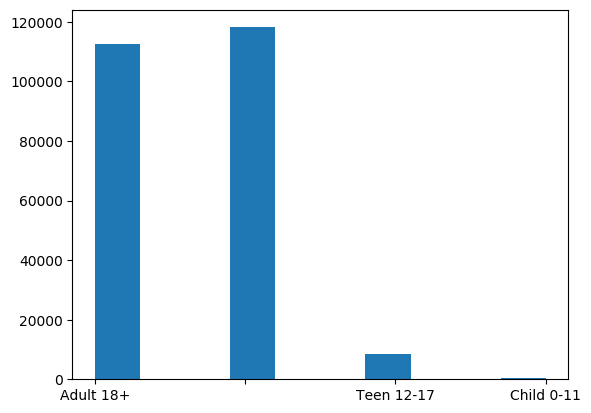

In [605]:
"""
New Suspect Age Group Column
Most suspects are adults 18+ category which doesn't tell us much, so the next column to create
is the actual age of the suspect (see next block in this notebook)
"""
import pandas as pd
import re
import math
import matplotlib.pyplot as plt

df['suspect_age'] = ''

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_type row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_age_group']
            regex = part_index + '::(.*)'
            #print("regex: %s" % regex)
            #print("temp_age_group: %s" % temp_age_group)
            if not isinstance(temp_age_group, float):
                match_age = re.findall(regex, temp_age_group)
                #print("match_age: %s" % match_age)
                if len(match_age) != 0:
                    if '||' in match_age[0]:
                        element = match_age[0].split('||')
                        if element[0] == '':
                            #print("empty element: --%s--" % element[0])
                            pass
                        df.at[i, 'suspect_age'] = element[0]
                    else:
                        df.at[i, 'suspect_age'] = match_age[0]
                        #print("i = %d" % i)
                else:
                    continue


print(df['suspect_age'].value_counts())
plt.clf()
plt.hist(df['suspect_age'])
plt.show()

## Significant Proportion Of Suspect Age Fell In 25-35 Age Range With The Ages Skewing Towards Younger Ages

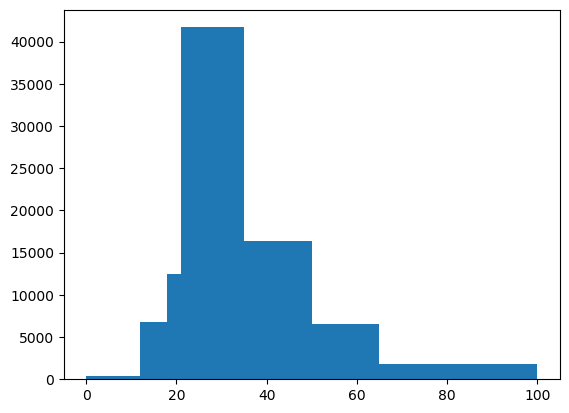

In [606]:
""""
Parse 'participant_type' and 'participant_age' column to get the suspect's actual age
"""
df['suspect_age_value'] = ''
df[['suspect_age_value']] = df[['suspect_age_value']].apply(pd.to_numeric)

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_type row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_age']
            regex = part_index + '::(.*)'
            #print("regex: %s" % regex)
            #print("temp_age_group: %s" % temp_age_group)
            if not isinstance(temp_age_group, float):
                match_age = re.findall(regex, temp_age_group)
                #print("match_age: %s" % match_age)
                if len(match_age) != 0:
                    if '||' in match_age[0]:
                        element = match_age[0].split('||')
                        if element[0] == '':
                            pass
                            #print("empty element: --%s--" % element[0])
                        else:
                            df.at[i, 'suspect_age_value'] = int(element[0])
                    else:
                        if match_age[0] == '':
                            #print("do nothing")
                            pass
                        else:
                            df.at[i, 'suspect_age_value'] = int(match_age[0])
                        #print("i = %d" % i)
                else:
                    continue


#print(df['suspect_age_value'].value_counts())
plt.clf()
#df = df.dropna(subset=['suspect_age_value'])
#print(type(df_temp.iloc[0]['suspect_age_value']))
#df_temp['suspect_age_value'] = df_temp['suspect_age_value'].apply(int)
#print("dataframe size: %d" % len(df))
plt.hist(df['suspect_age_value'], bins=[0,12,18,21,35,50,65,100])
plt.show()

## Overwhelming Majority of Suspects Were Male

size of dataframe at start: 239677


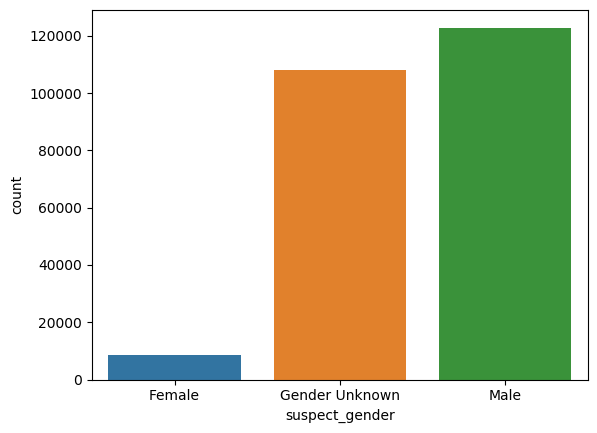

In [607]:
"""
'Gender Unknown' can mean two things:
1: There was a suspect but the gender was not recorded in the dataset
2: There was no suspect in the incident
"""

def has_numbers(inputString):
    if inputString != 'Male' and inputString != 'Female':
        #print("stop here")
        pass

    #print(type(inputString))
    for char in inputString:
        result = char.isdigit()
        if(result == True):
            return result
    #return any(char.isdigit() for char in inputString)
    
print("size of dataframe at start: %d" % len(df))

df['suspect_gender'] = ''
df[['suspect_gender']] = df[['suspect_gender']].apply(str)
# 0 = male
# 1 = female

# parse each column into readable form
for i, row in df.iterrows():

    temp = row['participant_type']
    #print("participant_gender row %s" % temp)

    if isinstance(temp, float):
        continue
    #match = re.findall('\d*::\d*Subject-Suspect', temp)
    match = re.findall('\d*::Subject-Suspect', temp)

    if len(match) == 0:
        continue
    elif 'Subject-Suspect' not in match[0]:
        continue


    for keyval in match:
        if '::' in str(keyval):
            #print("keyval: %s" % keyval)
            part_value = str(keyval).split('::')
            part_index = part_value[0]

            temp_age_group = row['participant_gender']
            regex = part_index + '::(.*)'
            #print("regex: %s" % regex)
            #print("temp_age_group: %s" % temp_age_group)
            if not isinstance(temp_age_group, float):
                match_age = re.findall(regex, temp_age_group)
                #print("match_age: %s" % match_age)
                if len(match_age) != 0:
                    if '||' in match_age[0]:
                        element = match_age[0].split('||')
                        if element[0] == '':
                            #print("empty element: --%s--" % element[0])
                            pass
                        else:
                            if has_numbers(element[0]):
                                df.at[i, 'suspect_gender'] = 'Gender Unknown'
                            else:
                                df.at[i, 'suspect_gender'] = element[0]
                    else:
                        if match_age[0] == '':
                            #print("do nothing")
                            pass
                        else:
                            if has_numbers(match_age[0]):
                                df.at[i, 'suspect_gender'] = 'Gender Unknown'
                            else:
                                df.at[i, 'suspect_gender'] = match_age[0]
                        #print("i = %d" % i)
                else:
                    continue


#print(df['suspect_gender'].value_counts())
plt.clf()
#print("number of rows before dropna(): %d" % len(df))
df_temp = df.dropna(subset=['suspect_gender'])
#print("number of rows after dropna(): %d" % len(df_temp))
#df_temp['suspect_gender'] = df['suspect_gender'].replace('0', 'Unknown')

for i,row in df_temp.iterrows():
    result = row['suspect_gender']
    if result != 'Female' and result != 'Male':
        df_temp.at[i, 'suspect_gender'] = 'Gender Unknown'
    #print(result)

import seaborn as sns

df = df_temp.copy()

sns.countplot(x = df['suspect_gender'], data = df)
plt.show()

In [608]:
print(df.columns)

Index(['incident_id', 'date', 'state', 'city_or_county', 'address', 'n_killed',
       'n_injured', 'incident_url', 'source_url',
       'incident_url_fields_missing', 'congressional_district', 'gun_stolen',
       'gun_type', 'incident_characteristics', 'latitude',
       'location_description', 'longitude', 'n_guns_involved', 'notes',
       'participant_age', 'participant_age_group', 'participant_gender',
       'participant_name', 'participant_relationship', 'participant_status',
       'participant_type', 'sources', 'state_house_district',
       'state_senate_district', 'target_class', 'region', 'victim_count',
       'suspect_count', 'n_total', 'suspect_age', 'suspect_age_value',
       'suspect_gender'],
      dtype='object')


In [609]:
df.drop(['state_house_district', 'state_senate_district'], axis=1, inplace=True)

In [610]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

In [611]:
df_selected_columns = df[['incident_id', 'date','year','state', 'city_or_county', 'congressional_district']]
df_selected_columns.head()

,incident_id,date,year,state,city_or_county,congressional_district
0,461105,2013-01-01,2013,Pennsylvania,Mckeesport,14.0
1,460726,2013-01-01,2013,California,Hawthorne,43.0
2,478855,2013-01-01,2013,Ohio,Lorain,9.0
3,478925,2013-01-05,2013,Colorado,Aurora,6.0
4,478959,2013-01-07,2013,North Carolina,Greensboro,6.0


In [612]:
df_congress = pd.read_csv("{}/Congress_2013-2018.csv".format(s3_path_3))
df_congress.head()

FileNotFoundError: sagemaker-us-east-1-898900188658/congress_data/Congress_2013-2018.csv

In [ ]:
df_states = pd.read_csv("{}/state_abbrev_map.csv".format(s3_path_2))
df_states.head()

In [ ]:
merged_df = df_congress.merge(df_states, left_on='state', right_on='code')
merged_df.drop(columns=['id', 'name', 'sort_name', 'email', 'twitter', 'facebook',
                        'group_id', 'chamber', 'start_date', 'state_x', 
                        'end_date', 'image', 'gender', 'wikidata', 'wikidata_group',
                        'wikidata_area', 'abbrev', 'code'], inplace=True)
merged_df.rename(columns={'state_y': 'state', 'district': 'congressional_district'}, inplace=True)
# Dropping duplicates to account for rep changes mid-term. Party always stays the same
# but is counted twice in the same year because 2 different people occupied the position
# that year (this is often the case when the congressperson gets an appointment to a higher
# office). 
merged_df = merged_df.drop_duplicates()
merged_df.head()

In [ ]:
print(df['congressional_district'].dtype)
print(merged_df['congressional_district'].dtype)

In [ ]:
merged_df['congressional_district'] = merged_df['congressional_district'].astype(float)
df = df.merge(merged_df, on=['state', 'congressional_district', 'year'])

In [ ]:
df_selected_columns = df[['incident_id', 'state', 'city_or_county', 'congressional_district', 'group', 'year']]
df_selected_columns.head()

In [ ]:
party_counts = merged_df['group'].value_counts()

party_counts.sort_index(inplace=True)

# Create a dictionary to specify the colors for each party
color_dict = {'Democrat': 'blue', 'Republican': 'red'}

# Create a bar chart using the party_counts and color dictionary
party_counts.plot(kind='bar', color=[color_dict.get(x) for x in party_counts.index])

# Set the title and labels for the bar chart
plt.title('Number of House Representatives per Political Party')
plt.xlabel('Political Party')
plt.ylabel('Number of House Representatives')

# Display the bar chart
plt.show()

In [ ]:
# Setting up a bar chart to show the amount of incident ids
# per political party
grouped_data = df.groupby('group')['incident_id'].count()

grouped_data.sort_index(inplace = True)

color_dict = {'Democrat': 'blue', 'Republican': 'red'}
grouped_data.plot(kind='bar', color=[color_dict.get(x) for x in grouped_data.index])

# Set the title and labels for the bar chart
plt.title('Number of Incidents per Congressional District Political Party ')
plt.xlabel('Political Party')
plt.ylabel('Number of Incidents')

# Display the bar chart
plt.show()

In [ ]:
# One hot encoding the "group" variable to cast "democrat" and "republican" 
# into boolean variables to use in the model. 
encoded_group = pd.get_dummies(df['group'], prefix='group')

df = pd.concat([df.drop('group', axis=1), encoded_group], axis=1)
df.head()

In [ ]:
# Get the list of column names
column_names = df.columns.tolist()

# Remove 'target_class' from the list
column_names.remove('target_class')
column_names.remove('year')
column_names.remove('address')
column_names.remove('city_or_county')
column_names.remove('zipcode')
column_names.remove('group_Democrat')
column_names.remove('group_Republican')

# Insert 'target_class' as the second column (index 1)
column_names.insert(1, 'target_class')
column_names.insert(2, 'year')
column_names.insert(4, 'address')
column_names.insert(5, 'city_or_county')
column_names.insert(7, 'zipcode')
column_names.insert(14, 'group_Democrat')
column_names.insert(15, 'group_Republican')

# Rearrange the DataFrame columns using the new order
df = df[column_names]

In [ ]:
df.isnull().sum()

In [ ]:
df.head()

## Incidents Per Adjusted Gross Income Level By ZipCode Overwhelmingly Skews To Lower Income Brackets

Chart of number of incidents by the adjusted gross income per zipcode

In [613]:
df_agi_by_zip = pd.read_csv("s3://sagemaker-us-east-1-898900188658/income_by_zip/combined_csv-cleaned.csv")
df_inc_zip = pd.read_csv("s3://sagemaker-us-east-1-898900188658/zipcodes/incident_zips.csv")

In [614]:
df_merged = df_inc_zip.merge(df_agi_by_zip,on='zipcode')
df_merged = df_merged[['incident_id', 'zipcode', 'agi', 'avg_agi', 'avg_income']]
df = df.merge(df_merged, on='incident_id')

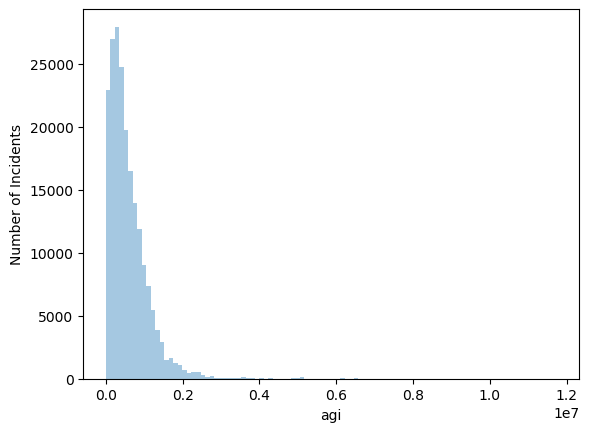

In [615]:
import seaborn as sns

plt.xlabel('Adjusted Gross Income By Zipcode (AGI)')
plt.ylabel('Number of Incidents')
sns.distplot(df['agi'],bins=100,kde=False)
plt.show()

## OneHotEncode Incident Characteristics Column

In [616]:
df['ohe_drug'] = 0
df['ohe_officer'] = 0
df['ohe_drug'] = 0
df['ohe_officer'] = 0
df['ohe_gang'] = 0
df['ohe_accident'] = 0
df['ohe_murder'] = 0
df['ohe_home_invasion'] = 0
df['ohe_suicide'] = 0
df['ohe_arrest'] = 0
df['ohe_officer'] = 0
df['ohe_brandishing'] = 0
df['ohe_felon'] = 0
df['ohe_drive'] = 0
df['ohe_home_invasion'] = 0
df['ohe_stolen'] = 0
df['ohe_misc'] = 0

# go through each incident in dataset
for i, row in df.iterrows():

    count = count + 1

    # if not null value
    if not isinstance(row['incident_characteristics'], float):
        # get the incident_characteristics column
        incident_text = row['incident_characteristics']

        # split by double bar to get the phrase
        if '||' in str(incident_text):
            item = str(incident_text).split('||')

            # in each phrase, check for keyword (ohe keyword)
            for phrase in item:
                phrase = phrase.lower()
                #phrases_list.append(phrases)
                if 'drug' in phrase:  # no caps sensitivity?
                    df.at[i, 'ohe_drugs'] = 1
                if 'officer' in phrase:
                    df.at[i, 'ohe_officer'] = 1
                if 'gang' in phrase:
                    df.at[i, 'ohe_gang'] = 1
                if 'DGU' in phrase:
                    df.at[i, 'ohe_defensive'] = 1
                if 'accident' in phrase:
                    df.at[i, 'ohe_accident'] = 1
                if 'defensive' in phrase:
                    df.at[i, 'ohe_defensive'] = 1
                if 'murder' in phrase:
                    df.at[i, 'ohe_murder'] = 1
                if 'home' in phrase:
                    df.at[i, 'ohe_home_invasion'] = 1
                if 'suicide' in phrase:
                    df.at[i, 'ohe_suicide'] = 1
                if 'arrest' in phrase:
                    df.at[i, 'ohe_arrest'] = 1
                if 'officer' in phrase:
                    df.at[i, 'ohe_officer'] = 1
                if 'brandishing' in phrase:
                    df.at[i, 'ohe_brandishing'] = 1
                if 'felon' in phrase:
                    df.at[i, 'ohe_felon'] = 1
                if 'drive' in phrase:
                    df.at[i, 'ohe_drive'] = 1
                if 'home' in phrase:
                    df.at[i, 'ohe_home_invasion'] = 1
                if 'car' in phrase:
                    df.at[i, 'ohe_car_jacking'] = 1
                if 'stolen' in phrase:
                    df.at[i, 'ohe_stolen'] = 1
                else:
                    df.at[i, 'ohe_misc'] = 1

In [617]:
# Impute Suspect Age and Suspect Age Group
df['suspect_age_value'].fillna(df['suspect_age_value'].mean(), inplace=True)
df['suspect_age'].fillna('Adult 18+', inplace=True)

In [618]:
# One Hot Encode Categorical Values
df = pd.get_dummies(df, columns=['suspect_gender'], drop_first=True)

In [621]:
# Bin the suspect age into custom age groups - provides more granularity than the original dataset's age group column
labels=['Child','Teen', 'Young Adult', 'Mid-Adult', 'Adult', 'Senior']
df['suspect_age_group']  = pd.cut(df['suspect_age_value'], bins=[1,12,18,25,35,65,200],labels=labels)
df = pd.get_dummies(df, columns=['suspect_age_group'], drop_first=True)

In [622]:
for col in df.columns:
    print(col)

incident_id
date
state
city_or_county
address
n_killed
n_injured
incident_url
source_url
incident_url_fields_missing
congressional_district
gun_stolen
gun_type
incident_characteristics
latitude
location_description
longitude
n_guns_involved
notes
participant_age
participant_age_group
participant_gender
participant_name
participant_relationship
participant_status
participant_type
sources
target_class
region
victim_count
suspect_count
n_total
suspect_age
suspect_age_value
year
zipcode
agi
avg_agi
avg_income
ohe_drug
ohe_officer
ohe_gang
ohe_accident
ohe_murder
ohe_home_invasion
ohe_suicide
ohe_arrest
ohe_brandishing
ohe_felon
ohe_drive
ohe_stolen
ohe_misc
ohe_drugs
ohe_car_jacking
ohe_defensive
suspect_gender_Gender Unknown
suspect_gender_Male
suspect_age_group_Teen
suspect_age_group_Young Adult
suspect_age_group_Mid-Adult
suspect_age_group_Adult
suspect_age_group_Senior


# Check for Associations

In [623]:
df.corr()

,incident_id,n_killed,n_injured,incident_url_fields_missing,congressional_district,latitude,longitude,n_guns_involved,target_class,victim_count,...,ohe_drugs,ohe_car_jacking,ohe_defensive,suspect_gender_Gender Unknown,suspect_gender_Male,suspect_age_group_Teen,suspect_age_group_Young Adult,suspect_age_group_Mid-Adult,suspect_age_group_Adult,suspect_age_group_Senior
incident_id,1.000000,0.002089,0.011699,NaN,-0.004312,0.022362,-0.017611,0.017224,0.022504,-0.072459,...,NaN,NaN,NaN,-0.030482,0.024492,0.019802,0.013270,-0.046609,0.041047,0.004154
n_killed,0.002089,1.000000,-0.118714,NaN,0.057677,-0.082045,-0.064291,-0.021194,0.392673,0.329975,...,NaN,NaN,NaN,-0.024905,0.023950,0.003963,0.030092,-0.095225,0.093864,0.058362
n_injured,0.011699,-0.118714,1.000000,NaN,-0.009629,-0.004066,0.035838,-0.032192,0.561546,0.585045,...,NaN,NaN,NaN,0.167528,-0.147145,-0.038421,-0.059756,0.126924,-0.092923,-0.025299
incident_url_fields_missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
congressional_district,-0.004312,0.057677,-0.009629,NaN,1.000000,-0.267009,-0.234047,0.018023,0.016607,0.014755,...,NaN,NaN,NaN,-0.006429,0.007407,-0.008274,-0.009771,0.010286,0.000362,0.005377
latitude,0.022362,-0.082045,-0.004066,NaN,-0.267009,1.000000,-0.019815,0.000053,-0.060132,-0.064613,...,NaN,NaN,NaN,0.021382,-0.015557,-0.002053,0.008473,-0.008300,0.008708,-0.007903
longitude,-0.017611,-0.064291,0.035838,NaN,-0.234047,-0.019815,1.000000,-0.014144,0.001101,-0.012833,...,NaN,NaN,NaN,0.036346,-0.029319,0.009198,0.024216,0.001742,-0.032929,-0.011513
n_guns_involved,0.017224,-0.021194,-0.032192,NaN,0.018023,0.000053,-0.014144,1.000000,-0.060715,-0.025209,...,NaN,NaN,NaN,-0.015105,0.011064,-0.000228,0.002588,-0.019326,0.025090,0.008393
target_class,0.022504,0.392673,0.561546,NaN,0.016607,-0.060132,0.001101,-0.060715,1.000000,0.293883,...,NaN,NaN,NaN,0.205850,-0.184079,-0.046093,-0.068207,0.104626,-0.052592,0.004033
victim_count,-0.072459,0.329975,0.585045,NaN,0.014755,-0.064613,-0.012833,-0.025209,0.293883,1.000000,...,NaN,NaN,NaN,-0.215045,0.207369,0.034809,0.067637,-0.087042,0.026887,0.017029


In [ ]:
## Chi-squared test for categorical variables

#### Creating a DataFrame with all categorical variables
## df_cat = pd.DataFrame(data = df, columns = 
## cat_var1=
## cat_var2=

## from itertools import product

#### Creating all possible combinations between the above two variables list
## cat_var_prod = list(product(cat_var1,cat_var2, repeat = 1))

#### Creating an empty variable and picking only the p value from the output of Chi-Square test
##result = []
##for i in cat_var_prod:
##    if i[0] != i[1]:
##        result.append((i[0],i[1],list(ss.chi2_contingency(pd.crosstab(
##                            df_cat_v1[i[0]], df_cat_v1[i[1]])))[1]))



In [ ]:
s3_path__temp_folder =  "s3://{}/temp_folder".format(bucket)
df.to_csv("{}/notebook1.csv".format(s3_path_temp_folder))